This notebook contains a generator class for Keras called BSONIterator that can read directly from the BSON data. You can use it in combination with ImageDataGenerator for doing data augmentation.

source:
https://www.kaggle.com/humananalog/keras-generator-for-reading-directly-from-bson

In [1]:
import numpy as np
import pandas as pd
import multiprocessing as mp
import bson # from pymongo
import struct
import os

%matplotlib inline
import matplotlib.pyplot as plt

import keras
from keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf

from collections import defaultdict
from tqdm import *

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.
/home/aind2/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


category_names.csv
sample_submission.csv
test.bson
train.bson
train_example.bson



In [2]:
# Use version 2.0.9 other version get stuck in validation step
keras.__version__, tf.__version__

('2.0.9', '1.4.0')

In [3]:
data_dir = "input/"

train_bson_path = os.path.join(data_dir, "train.bson")
num_train_products = 7069896

# train_bson_path = os.path.join(data_dir, "train_example.bson")
# num_train_products = 82

test_bson_path = os.path.join(data_dir, "test.bson")
num_test_products = 1768182

### Part 1: Create lookup tables
The generator uses several lookup tables that describe the layout of the BSON file, which products and images are part of the training/validation sets, and so on.

You only need to generate these tables once, as they get saved to CSV files. If you already have these CSV files, skip to part 2.

In [4]:
categories_path = os.path.join(data_dir, "category_names.csv")
categories_df = pd.read_csv(categories_path, index_col="category_id")

# Maps the category_id to an integer index. This is what we'll use to
# one-hot encode the labels.
categories_df["category_idx"] = pd.Series(range(len(categories_df)), index=categories_df.index)

categories_df.to_csv("categories.csv")
categories_df.head()

,category_level1,category_level2,category_level3,category_idx
category_id,,,,
1000021794,ABONNEMENT / SERVICES,CARTE PREPAYEE,CARTE PREPAYEE MULTIMEDIA,0
1000012764,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI FUMEUR,1
1000012776,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI VELO - ABRI MOTO,2
1000012768,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,FONTAINE A EAU,3
1000012755,AMENAGEMENT URBAIN - VOIRIE,SIGNALETIQUE,PANNEAU D'INFORMATION EXTERIEUR,4


In [5]:
# Create dictionaries for quick lookup of category_id to category_idx mapping.
def make_category_tables():
    cat2idx = {}
    idx2cat = {}
    for ir in categories_df.itertuples():
        category_id = ir[0]
        category_idx = ir[4]
        cat2idx[category_id] = category_idx
        idx2cat[category_idx] = category_id
    return cat2idx, idx2cat

cat2idx, idx2cat = make_category_tables()

# Test if it works
(cat2idx[1000012755], idx2cat[4])

(4, 1000012755)

### Read the BSON files
We store the offsets and lengths of all items, allowing us random access to the items later.

Inspired by code from: https://www.kaggle.com/vfdev5/random-item-access

In [14]:
###
### Note: this takes a few minutes to execute, 
### but we only have to do it once (we'll save the table to a CSV file afterwards).
###

def read_bson(bson_path, num_records, with_categories):
    rows = {}
    with open(bson_path, "rb") as f, tqdm(total=num_records) as pbar:
        offset = 0
        while True:
            item_length_bytes = f.read(4)
            if len(item_length_bytes) == 0:
                break

            length = struct.unpack("<i", item_length_bytes)[0]

            f.seek(offset)
            item_data = f.read(length)
            assert len(item_data) == length

            item = bson.BSON.decode(item_data)
            product_id = item["_id"]
            num_imgs = len(item["imgs"])

            row = [num_imgs, offset, length]
            if with_categories:
                row += [item["category_id"]]
            rows[product_id] = row

            offset += length
            f.seek(offset)
            pbar.update()

    columns = ["num_imgs", "offset", "length"]
    if with_categories:
        columns += ["category_id"]

    df = pd.DataFrame.from_dict(rows, orient="index")
    df.index.name = "product_id"
    df.columns = columns
    df.sort_index(inplace=True)
    return df

In [5]:
%time train_offsets_df = read_bson(train_bson_path, num_records=num_train_products, with_categories=True)

NameError: name 'read_bson' is not defined

In [16]:
# train_offsets_df.to_csv("train_offsets.csv")

In [6]:
train_offsets_df = pd.read_csv('train_offsets.csv')

In [8]:
# Read DF from CSV
# train_offsets_df.to_csv("train_offsets.csv")
train_offsets_df.head()

,product_id,num_imgs,offset,length,category_id
0,0,1,0,6979,1000010653
1,1,1,6979,7318,1000010653
2,2,1,14297,5455,1000004079
3,3,1,19752,4580,1000004141
4,4,1,24332,6346,1000015539


In [9]:
print("Number of products: ", len(train_offsets_df))
print("Number of categories: ", len(train_offsets_df["category_id"].unique()))
print("Number of images: ", train_offsets_df["num_imgs"].sum())

Number of products:  7069896
Number of categories:  5270
Number of images:  12371293


### Create a random train/validation split

We split on products, not on individual images. Since some of the categories only have a few products, we do the split separately for each category.

This creates two new tables, one for the training images and one for the validation images. There is a row for every single image, so if a product has more than one image it occurs more than once in the table.

In [16]:
def make_val_set(df, split_percentage=0.2, drop_percentage=0.9):
    # Find the product_ids for each category.
    category_dict = defaultdict(list)
    
    for ir in tqdm(df.itertuples()):
        category_dict[ir[4]].append(ir[0])

    train_list = []
    val_list = []
    
    with tqdm(total=len(df)) as pbar:
        for category_id, product_ids in category_dict.items():
            category_idx = cat2idx[category_id]

            # Randomly remove products to make the dataset smaller.
            keep_size = int(len(product_ids) * (1.0 - drop_percentage))
            if keep_size < len(product_ids):
                product_ids = np.random.choice(product_ids, keep_size, replace=False)

            # Randomly choose the products that become part of the validation set.
            val_size = int(len(product_ids) * split_percentage)
            if val_size > 0:
                val_ids = np.random.choice(product_ids, val_size, replace=False)
            else:
                val_ids = []

            # Create a new row for each image.
            for product_id in product_ids:
                row = [product_id, category_idx]
                for img_idx in range(df.loc[product_id, "num_imgs"]):
                    if product_id in val_ids:
                        val_list.append(row + [img_idx])
                    else:
                        train_list.append(row + [img_idx])
                pbar.update()
                
    columns = ["product_id", "category_idx", "img_idx"]
    train_df = pd.DataFrame(train_list, columns=columns)
    val_df = pd.DataFrame(val_list, columns=columns)
    
    return train_df, val_df

Create a 80/20 split. Also drop 90% of all products to make the dataset more manageable. (Note: if drop_percentage > 0, the progress bar doesn't go all the way.)

In [17]:
train_images_df, val_images_df = make_val_set(train_offsets_df, split_percentage=0.2,drop_percentage=0.9)

7069896it [00:09, 774996.87it/s]
  0%|          | 0/7069896 [00:00<?, ?it/s]


KeyError: 6979

In [10]:
# save DFs
# train_images_df.to_csv("train_images.csv")
# val_images_df.to_csv("val_images.csv")

train_images_df = pd.read_csv("train_images.csv")
val_images_df = pd.read_csv("val_images.csv")

# train_images_df.head()
# val_images_df.head()

In [11]:
print("Number of training images:", len(train_images_df))
print("Number of validation images:", len(val_images_df))
print("Total images:", len(train_images_df) + len(val_images_df))

Number of training images: 989351
Number of validation images: 241906
Total images: 1231257


#### Are all categories represented in the train/val split? 
(Note: if the drop percentage is high, then very small categories won't have enough products left to make it into the validation set.)

In [12]:
len(train_images_df["category_idx"].unique()), len(val_images_df["category_idx"].unique())


(5270, 4268)

Quickly verify that the split really is approximately 80-20:

In [13]:
category_idx = 619
num_train = np.sum(train_images_df["category_idx"] == category_idx)
num_val = np.sum(val_images_df["category_idx"] == category_idx)
num_val / num_train

0.2722222222222222

Close enough. ;-) Remember that we split on products but not all products have the same number of images, which is where the slightly discrepancy comes from. (Also, there tend to be fewer validation images if drop_percentage > 0.)

## Part 2

First load the lookup tables from the CSV files

In [14]:
categories_df = pd.read_csv("categories.csv", index_col=0)
cat2idx, idx2cat = make_category_tables()

train_offsets_df = pd.read_csv("train_offsets.csv", index_col=0)
train_images_df = pd.read_csv("train_images.csv", index_col=0)
val_images_df = pd.read_csv("val_images.csv", index_col=0)

/home/aind2/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


The Keras generator is implemented by the BSONItereator class. It creates batches of images(and their one hot encoded labels) directly from the BSON file. It can be used with multiple workers.


In [15]:
from keras.preprocessing.image import Iterator
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import io


class BSONIterator(Iterator):
    def __init__(self, bson_file, images_df, offsets_df, num_class,
                 image_data_generator, lock, target_size=(180, 180), 
                 with_labels=True, batch_size=32, shuffle=False, seed=None):

        self.file = bson_file
        self.images_df = images_df
        self.offsets_df = offsets_df
        self.with_labels = with_labels
        self.samples = len(images_df)
        self.num_class = num_class
        self.image_data_generator = image_data_generator
        self.target_size = tuple(target_size)
        self.image_shape = self.target_size + (3,)

        print("Found %d images belonging to %d classes." % (self.samples, self.num_class))

        super(BSONIterator, self).__init__(self.samples, batch_size, shuffle, seed)
        self.lock = lock

    def _get_batches_of_transformed_samples(self, index_array):
        batch_x = np.zeros((len(index_array),) + self.image_shape, dtype=K.floatx())
        if self.with_labels:
            batch_y = np.zeros((len(batch_x), self.num_class), dtype=K.floatx())

        for i, j in enumerate(index_array):
            # Protect file and dataframe access with a lock.
            with self.lock:
                image_row = self.images_df.iloc[j]
                product_id = image_row["product_id"]
                offset_row = self.offsets_df.loc[product_id]

                # Read this product's data from the BSON file.
                self.file.seek(offset_row["offset"])
                item_data = self.file.read(offset_row["length"])

            # Grab the image from the product.
            item = bson.BSON.decode(item_data)
            img_idx = image_row["img_idx"]
            bson_img = item["imgs"][img_idx]["picture"]

            # Load the image.
            img = load_img(io.BytesIO(bson_img), target_size=self.target_size)

            # Preprocess the image.
            x = img_to_array(img)
            x = self.image_data_generator.random_transform(x)
            x = self.image_data_generator.standardize(x)

            # Add the image and the label to the batch (one-hot encoded).
            batch_x[i] = x
            if self.with_labels:
                batch_y[i, image_row["category_idx"]] = 1

        if self.with_labels:
            return batch_x, batch_y
        else:
            return batch_x

    def next(self):
        with self.lock:
            index_array = next(self.index_generator)
        return self._get_batches_of_transformed_samples(index_array)

In [16]:
train_bson_file = open(train_bson_path, "rb")

Because the training and validation generators read from the same BSON file, they need to use the same lock to protect it.

In [17]:
import threading
lock = threading.Lock()

Create a generator for training and generator for validation

In [18]:
num_classes = 5270
num_train_images = len(train_images_df)
num_val_images = len(val_images_df)
batch_size = 128

# Use ImageDataGenerator for data augmentation and preprocessing
train_datagen = ImageDataGenerator()
train_gen = BSONIterator(train_bson_file, train_images_df, train_offsets_df,
                        num_classes, train_datagen, lock, batch_size = batch_size, shuffle=True)

val_datagen = ImageDataGenerator()
val_gen = BSONIterator(train_bson_file, val_images_df, train_offsets_df,
                      num_classes, val_datagen, lock, batch_size = batch_size, shuffle=True)

Found 989351 images belonging to 5270 classes.
Found 241906 images belonging to 5270 classes.


How fast is generator? Create a single batch:

In [19]:
next(train_gen)

%time bx, by = next(train_gen)

CPU times: user 148 ms, sys: 12 ms, total: 160 ms
Wall time: 299 ms


Dose it really output images and one hot encoded class labels? 

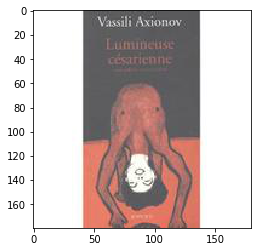

In [20]:
plt.imshow(bx[-1].astype(np.uint8))

In [21]:
cat_idx = np.argmax(by[-1])
cat_id = idx2cat[cat_idx]
categories_df.loc[cat_id]

category_level1                LIBRAIRIE
category_level2              LITTERATURE
category_level3    LITTERATURE ETRANGERE
category_idx                        3334
Name: 1000014199, dtype: object

## Part3 Training
create a very simple Keras model and train it, to test that the generators work

### Simple model

In [22]:
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D, GlobalAveragePooling2D

model = Sequential()
model.add(Conv2D(32, 3, padding="same", activation="relu", input_shape=(180, 180, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPooling2D())
model.add(Conv2D(128, 3, padding="same", activation="relu"))
model.add(MaxPooling2D())
model.add(GlobalAveragePooling2D())
model.add(Dense(num_classes, activation="softmax"))

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 45, 45, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 22, 22, 128)       0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 128)               0         
__________

### Exception model

In [13]:
from keras.applications.xception import Xception
from keras.layers import Flatten, Dense, AveragePooling2D, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard


model_name = "xception_v2"
models_savename = "./models/" + model_name

classnames = pd.read_csv("input/category_names.csv", "rb")

train_data_dir = "output/train"
val_data_dir = "output/validation"

batch_size = 256  # or for 3 GPUs 56 x 3
img_width = 180
img_height = 180


model0 = Xception(include_top=False, 
                  weights='imagenet',
                  input_tensor=None, 
                  input_shape=(img_width, img_height, 3))

# Freeze the layers 
for lay in model0.layers:
    lay.trainable = False
    
x = model0.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dropout(0.2)(x)
x = Dense(len(classnames), activation='softmax', name='predictions')(x)

# Train on one GPU
model = Model(model0.input, x)

model.summary()

/home/aind2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  del sys.path[0]


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 180, 180, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 89, 89, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 89, 89, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 89, 89, 32)   0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [ ]:
os.makedirs("./models", exist_ok=True)

callbacks = [ModelCheckpoint(monitor='val_loss',
                             filepath= models_savename + '_{epoch:03d}-{val_loss:.7f}.hdf5',
                             save_best_only=False,
                             save_weights_only=False,
                             mode='max'),
             TensorBoard(log_dir='logs/{}'.format(model_name))]

model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.001, momentum=0.9), metrics=[top_k_categorical_accuracy, 'accuracy'])


In [23]:
# To train the model:
model.fit_generator(train_gen,
                    steps_per_epoch = 10,   #num_train_images // batch_size,
                    epochs = 3,
                    validation_data = val_gen,
                    validation_steps = 10,  #num_val_images // batch_size,
                    workers = 8)

Epoch 1/3
10/10 [==============================] - 134s 13s/step - loss: 9.3070 - acc: 0.0055 - val_loss: 7.8036 - val_acc: 0.0016
Epoch 2/3
10/10 [==============================] - 131s 13s/step - loss: 7.3983 - acc: 0.0047 - val_loss: 7.2366 - val_acc: 0.0102
Epoch 3/3
10/10 [==============================] - 130s 13s/step - loss: 7.2693 - acc: 0.0070 - val_loss: 7.1510 - val_acc: 0.0094


In [ ]:
def make_val_set(df, split_percentage=0.2, drop_percentage=0.9):
    # Find the product_ids for each category.
    category_dict = defaultdict(list)
    
    for ir in tqdm(df.itertuples()):
        category_dict[ir[4]].append(ir[0])

    train_list = []
    val_list = []
    
    with tqdm(total=len(df)) as pbar:
        for category_id, product_ids in category_dict.items():
            category_idx = cat2idx[category_id]

            # Randomly remove products to make the dataset smaller.
            keep_size = int(len(product_ids) * (1.0 - drop_percentage))
            if keep_size < len(product_ids):
                product_ids = np.random.choice(product_ids, keep_size, replace=False)

            # Randomly choose the products that become part of the validation set.
            val_size = int(len(product_ids) * split_percentage)
            if val_size > 0:
                val_ids = np.random.choice(product_ids, val_size, replace=False)
            else:
                val_ids = []

            # Create a new row for each image.
            for product_id in product_ids:
                row = [product_id, category_idx]
                for img_idx in range(df.loc[product_id, "num_imgs"]):
                    if product_id in val_ids:
                        val_list.append(row + [img_idx])
                    else:
                        train_list.append(row + [img_idx])
                pbar.update()
                
    columns = ["product_id", "category_idx", "img_idx"]
    train_df = pd.DataFrame(train_list, columns=columns)
    val_df = pd.DataFrame(val_list, columns=columns)
    
    return train_df, val_df

## Test set prediction

In [24]:
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import preprocess_input

submission_df = pd.read_csv(data_dir + "sample_submission.csv")
submission_df.head()

,_id,category_id
0,10,1000010653
1,14,1000010653
2,21,1000010653
3,24,1000010653
4,27,1000010653


In [27]:
val_datagen = ImageDataGenerator()
val_gen = BSONIterator(train_bson_file, val_images_df, train_offsets_df,
                      num_classes, val_datagen, lock, batch_size = batch_size, shuffle=True)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
# Generator
data = bson.decode_file_iter(open(test_bson_path, "rb"))

Found 241906 images belonging to 5270 classes.


In [28]:
# change it from 1768182 to 1768
num_test_products = 1768
with tqdm(total=num_test_products) as pbar:
    for c, d in enumerate(data):
        product_id = d["_id"]
        num_imgs = len(d["imgs"])
        
        # Randomly remove products to make the dataset smaller.
        #keep_size = int(len(product_ids) * (1.0 - drop_percentage))
        #if keep_size < len(product_ids):
         #   product_ids = np.random.choice(product_ids, keep_size, replace=False)


        batch_x = np.zeros((num_imgs, 180, 180, 3), dtype=K.floatx())

        for i in range(num_imgs):
            bson_img = d["imgs"][i]["picture"]

            # Load and preprocess the image.
            img = load_img(io.BytesIO(bson_img), target_size=(180, 180))
            x = img_to_array(img)
            x = test_datagen.random_transform(x)
            x = test_datagen.standardize(x)

            # Add the image to the batch.
            batch_x[i] = x

        prediction = model.predict(batch_x, batch_size=num_imgs)
        avg_pred = prediction.mean(axis=0)
        cat_idx = np.argmax(avg_pred)

        submission_df.iloc[c]["category_id"] = idx2cat[cat_idx]        
        pbar.update()

submission_df.to_csv("my_submission.csv.gz", compression="gzip", index=False)

5083it [03:48, 22.23it/s]                          


KeyboardInterrupt: 

In [30]:
len(submission_df)

1768182